<a href="https://colab.research.google.com/github/Suhas1131/dark-matter-1221/blob/main/GW_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
#installing gwpy
! pip install gwpy

The following example is from: https://gwpy.github.io/docs/stable/examples/signal/gw150914/

In [26]:
# # -- Set a GPS time:
#t0 = 1126259462.4    # -- GW150914
#t0 = 1187008882.4    # -- GW170817
t0 = 1242459857.4     # -- GW190521_074359

from gwpy.timeseries import TimeSeries
hdata = TimeSeries.fetch_open_data('H1', t0-16, t0+16) #pick a time with a 32 day window around t0

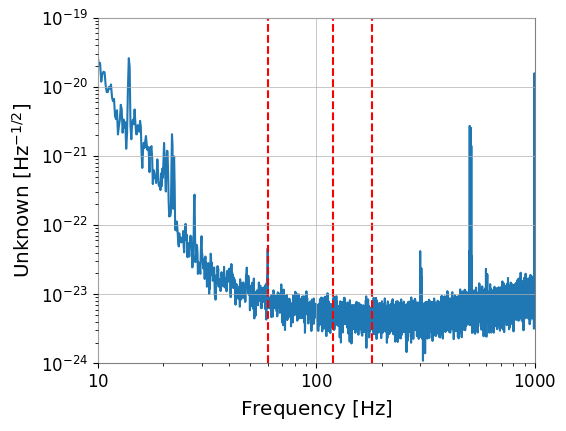

In [27]:
import matplotlib.pyplot as plt

# -- Plot ASD
fig2 = hdata.asd(fftlength=8).plot()
plt.xlim(10,1000)
ymin = 1e-24
ymax = 1e-19
plt.ylim(ymin, ymax)
#marking unwanted peaks in data
plt.vlines(60, ymin, ymax, linestyle="dashed", color="red")
plt.vlines(120, ymin, ymax, linestyle="dashed", color="red")
plt.vlines(180, ymin, ymax, linestyle="dashed", color="red")

In [28]:
#filtering frequencies
from gwpy.signal import filter_design
bp = filter_design.bandpass(50, 250, hdata.sample_rate)
#removing unwanted peaks in plot
notches = [filter_design.notch(line, hdata.sample_rate) for
           line in (60, 120, 180)]

zpk = filter_design.concatenate_zpks(bp, *notches)

hfilt = hdata.filter(zpk, filtfilt=True)


In [29]:
#removing unwanted frequencies
hdata = hdata.crop(*hdata.span.contract(1))
hfilt = hfilt.crop(*hfilt.span.contract(1))

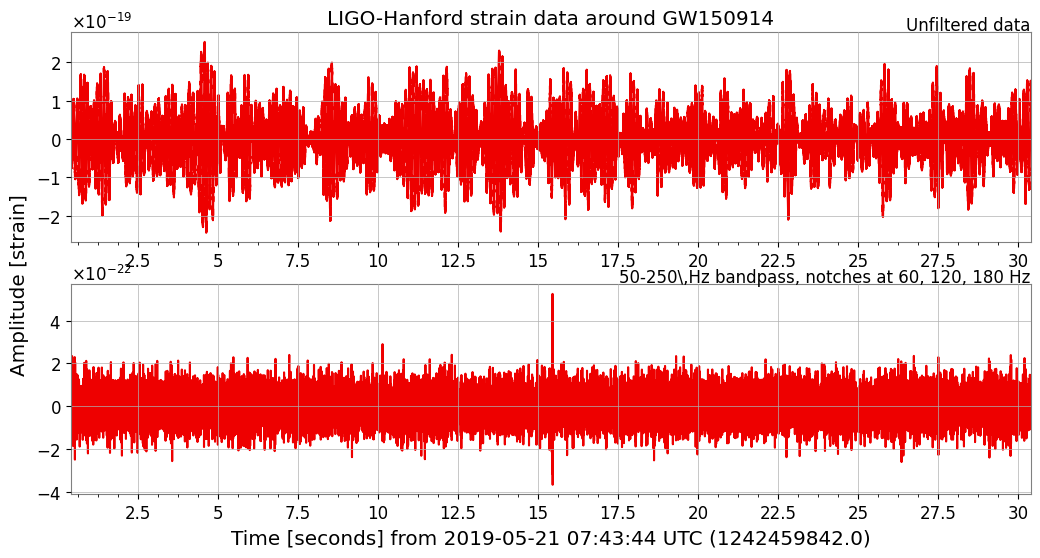

In [30]:
#Plotting LIGO data before and after removing the unwanted peaks

from gwpy.plot import Plot
plot = Plot(hdata, hfilt, figsize=[12, 6], separate=True, sharex=True,
            color='gwpy:ligo-hanford')
ax1, ax2 = plot.axes
ax1.set_title('LIGO-Hanford strain data around GW150914')
ax1.text(1.0, 1.01, 'Unfiltered data', transform=ax1.transAxes, ha='right')
ax1.set_ylabel('Amplitude [strain]', y=-0.2)
ax2.set_ylabel('')
ax2.text(1.0, 1.01, r'50-250\,Hz bandpass, notches at 60, 120, 180 Hz',
         transform=ax2.transAxes, ha='right')
plot.show()

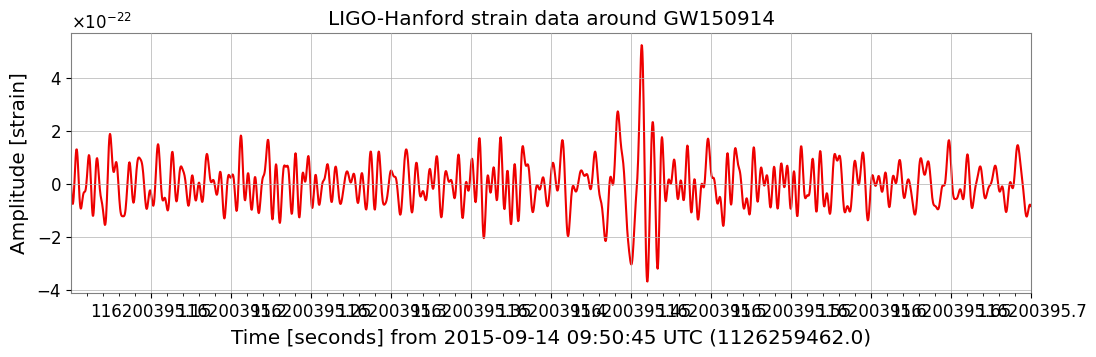

In [31]:
#plotting LIGO data for a shorter x-value range

import matplotlib.pyplot as plt
#plotting data from LIGO station at Hanford
plot = hfilt.plot(color='gwpy:ligo-hanford')
ax = plot.gca()
ax.set_title('LIGO-Hanford strain data around GW150914')
ax.set_ylabel('Amplitude [strain]')
ax.set_xlim(t0-0.3, t0+0.3)
ax.set_xscale('seconds', epoch=1126259462)
plot.show()
#storing the values of x and y in new variables
x_val = plt.gca().lines[0].get_xdata()
y_val = plt.gca().lines[0].get_ydata()


In [32]:
ldata = TimeSeries.fetch_open_data('L1', t0-16, t0+16)
lfilt = ldata.filter(zpk, filtfilt=True)

In [33]:
#GW reaches Livingston 6.9ms after Hanford
lfilt.shift('6.9ms')
lfilt *= -1 #opposite phase at both locations

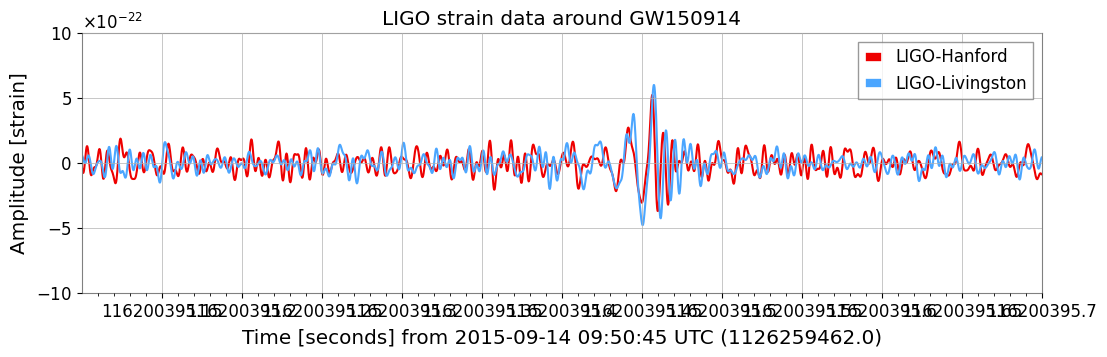

In [34]:
#plotting data for both stations together
plot = Plot(figsize=[12, 4])
ax = plot.gca()
ax.plot(hfilt, label='LIGO-Hanford', color='gwpy:ligo-hanford')
ax.plot(lfilt, label='LIGO-Livingston', color='gwpy:ligo-livingston')
ax.set_title('LIGO strain data around GW150914')
ax.set_xlim(t0 - 0.3, t0 + 0.3)
ax.set_xscale('seconds', epoch=1126259462)
ax.set_ylabel('Amplitude [strain]')
ax.set_ylim(-1e-21, 1e-21)
ax.legend()
plot.show()

https://colab.research.google.com/github/losc-tutorial/quickview/blob/master/index.ipynb
Also from: https://gwpy.github.io/docs/stable/examples/signal/qscan/

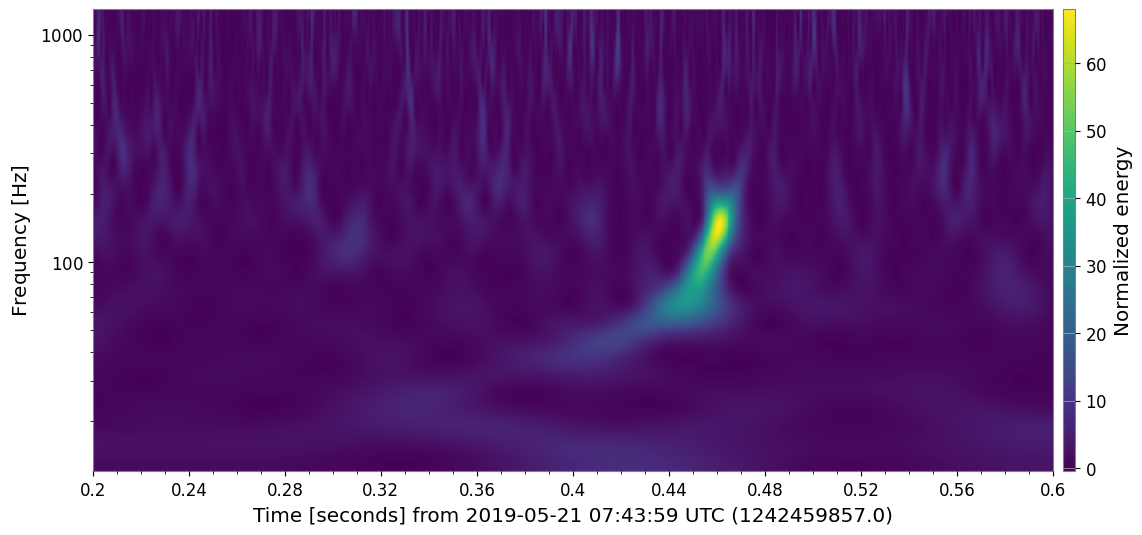

In [35]:
#plotting frequency and intensity
dt = 0.2  #-- Set width of q-transform plot, in seconds
hq = hfilt.q_transform(outseg=(t0-dt, t0+dt))
fig4 = hq.plot()
ax = fig4.gca()
fig4.colorbar(label="Normalized energy")
ax.grid(False)
ax.set_yscale('log')

In [36]:
#importing libraries
from scipy.io.wavfile import write
import numpy as np

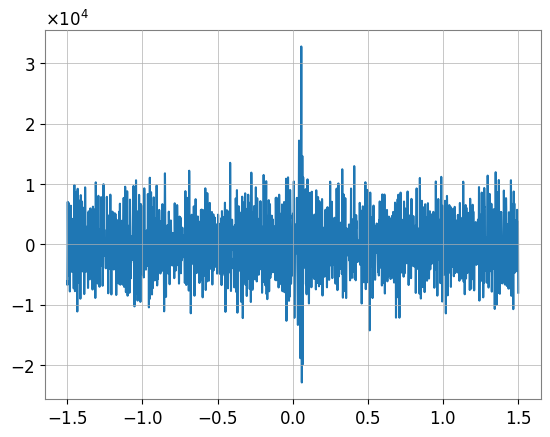

In [37]:
amplitude = np.iinfo(np.int16).max

ind = np.where((x_val < (t0+1.5)) & (x_val > (t0-1.5)))
y = y_val[ind]
#y = y**3
y = y / np.max(y)
plt.plot(x_val[ind] - t0, (np.array(y) * amplitude).astype(np.int16))

In [38]:
#example wave
fs = int(1 / np.median(np.diff(np.array(x_val[ind] - t0))))
print("fs = ", fs)
write("example.wav", fs, (np.array(y) * amplitude).astype(np.int16))

fs =  4096


In [39]:
from google.colab import files
files.download("example.wav")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.5
fs =  4096


<ipython-input-40-8fed1acd420f>:43: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.plot(x - t0, (np.array(y_old) * amplitude).astype(np.int16), label="before frequency multiplication")
<ipython-input-40-8fed1acd420f>:50: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.plot(x - t0, (np.array(y) * amplitude).astype(np.int16), label="after frequency multiplication")
<ipython-input-40-8fed1acd420f>:58: ComplexWarning: Casting complex values to real discards the imaginary part
  write("example.wav", fs, (np.array(y[0:int(num/up_sample)]) * amplitude).astype(np.int16))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

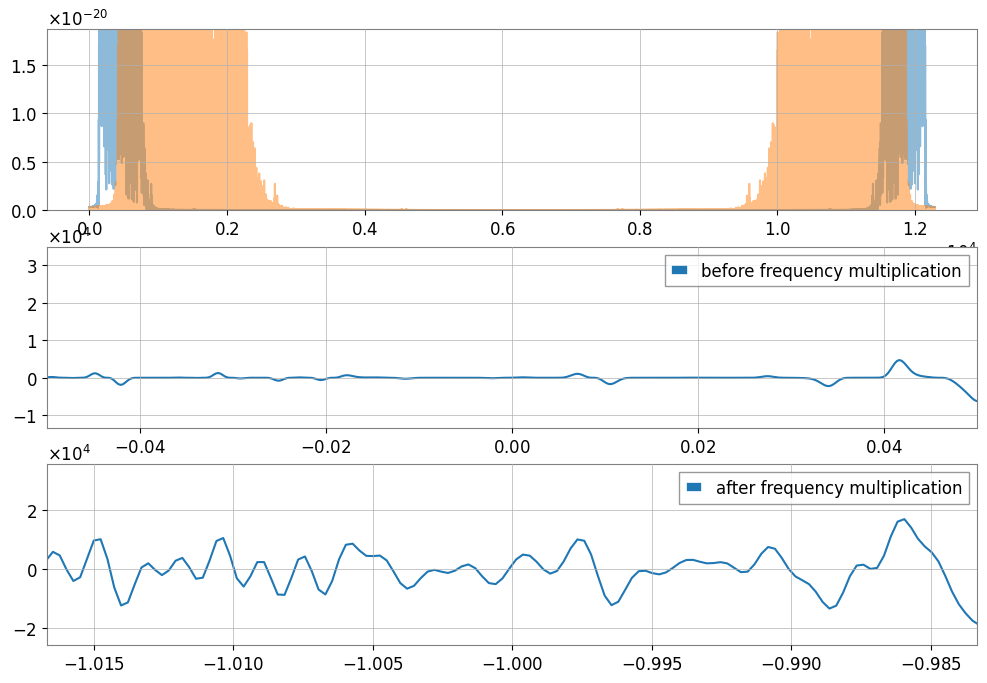

In [40]:
t_clip = 1.5
amplitude = np.iinfo(np.int16).max

#selecting a time frame of 3 seconds in which the event takes place
ind = np.where((x_val < (t0+t_clip)) & (x_val > (t0-t_clip)))
x = x_val[ind]  #x-axis = time
y = y_val[ind]  #y-axis = amplitude

# plt.plot(x - t0, (np.array(y / np.max(y)) * amplitude) + 10000, label="oringinal")
# print(np.min(np.array(y / np.max(y)) * amplitude), np.max(np.array(y / np.max(y)) * amplitude))

up_sample = 3

y_fft = np.fft.fft(y)   #fourier transform of the gravitational wave data
y_fft_new = np.zeros(np.shape(y_fft), dtype=np.cdouble)
y_fft_old = y_fft

num = len(y_fft)
for i in np.arange(int(num / up_sample)):
    y_fft_new[int(i * up_sample)] = y_fft[int(i)]

y_old = np.fft.ifft(y_fft_old)

for i in np.arange(num):
  if i > (num / 2):
    y_fft_new[i] = np.conjugate(y_fft_new[int(num) - i])

# y_fft_new = np.fft.fftshift(y_fft_new)
y = np.fft.ifft(y_fft_new)

plt.figure(figsize=(12,8))
plt.subplot(311)
#Plotting the data before the fourier transform
plt.plot(np.abs(y_fft_old), alpha=0.5)
#Plotting the data after the fourier transform
plt.plot(np.abs(y_fft_new), alpha=0.5)
ylim = np.percentile(np.abs(y_fft), 95)
plt.ylim(0, ylim)

plt.subplot(312)
y_old = y_old**3 # to make the signal more distinct from the noise
y_old = y_old / np.max(y_old)
plt.plot(x - t0, (np.array(y_old) * amplitude).astype(np.int16), label="before frequency multiplication")
plt.xlim(-0.05, 0.05)
plt.legend()

plt.subplot(313)
# y = y**3 # to make the signal more distinct from the noise
y = y / np.max(y)
plt.plot(x - t0, (np.array(y) * amplitude).astype(np.int16), label="after frequency multiplication")
plt.xlim(-t_clip + t_clip / up_sample - 0.05 / up_sample, -t_clip + t_clip / up_sample + 0.05 / up_sample)
plt.legend()
print(t_clip / up_sample)

fs = int(1 / np.median(np.diff(np.array(x_val[ind] - t0))))
# fs = fs * 4 # to make the signal higher pitch
print("fs = ", fs)
write("example.wav", fs, (np.array(y[0:int(num/up_sample)]) * amplitude).astype(np.int16))

from google.colab import files
files.download("example.wav")

In [41]:
#Original data, old data, and new data
print(y_fft[0:4], y_fft[-3:])
print(y_fft_new[0:10], y_fft_new[-3:])
print(y_fft_old[0:4], y_fft_old[-3:])


[3.52843988e-22+0.00000000e+00j 3.52855713e-22+1.83729834e-24j
 3.52890893e-22+3.67480641e-24j 3.52949536e-22+5.51273472e-24j] [3.52949536e-22-5.51273472e-24j 3.52890893e-22-3.67480641e-24j
 3.52855713e-22-1.83729834e-24j]
[3.52843988e-22+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
 0.00000000e+00+0.00000000e+00j 3.52855713e-22+1.83729834e-24j
 0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
 3.52890893e-22+3.67480641e-24j 0.00000000e+00+0.00000000e+00j
 0.00000000e+00+0.00000000e+00j 3.52949536e-22+5.51273472e-24j] [3.52855713e-22-1.83729834e-24j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j]
[3.52843988e-22+0.00000000e+00j 3.52855713e-22+1.83729834e-24j
 3.52890893e-22+3.67480641e-24j 3.52949536e-22+5.51273472e-24j] [3.52949536e-22-5.51273472e-24j 3.52890893e-22-3.67480641e-24j
 3.52855713e-22-1.83729834e-24j]


In [42]:
#Importing package to edit sound file
!pip install pydub
from pydub import AudioSegment

In [43]:
#Slowing down the sound
sound = AudioSegment.from_file("example.wav")
print(sound.frame_rate)
# sound.frame_rate = 1024
print(sound.frame_rate)
sound = sound.set_frame_rate(4096 * 4)
sound.frame_rate = 4096 * 2
sound.export("example_slow.wav")
files.download("example_slow.wav")


4096
4096


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Make C

(0.0, 0.1)

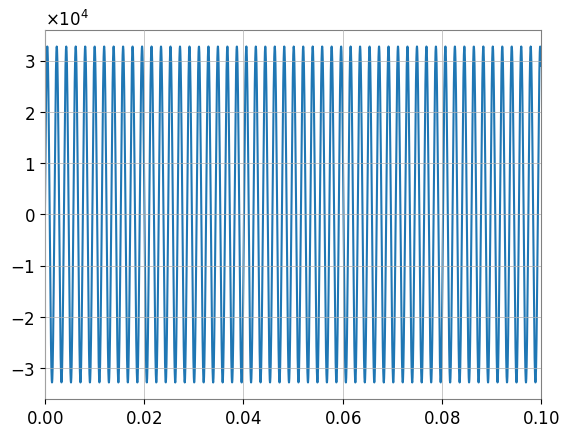

In [44]:
#creating a plot for the C key of an instrument for 1 second
samplerate = 44100; fs = 261.63 * 2.0
t = np.linspace(0., 1., samplerate)
amplitude = np.iinfo(np.int16).max
data = amplitude * np.sin(2. * np.pi * fs * t)
plt.plot(t, data)
plt.xlim(0, 0.1)

In [45]:
#downloading a file for the C key
from google.colab import files
write("C.wav", samplerate, data.astype(np.int16))
files.download("C.wav")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>